In [1]:
import  os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import json
from FBSDE_Filter import Deep_FBSDE_Filter, build_Zakai_Solver
from munch import Munch

project_dir = str(Path(os.getcwd()).resolve())
sys.path.append(project_dir)

2024-08-27 10:23:23.786415: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 10:23:23.832200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:23:23.832227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:23:23.833295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 10:23:23.839393: I tensorflow/core/platform/cpu_feature_guar

In [2]:
@tf.function
def noised_observation(data, drift, delta_t) -> tf.Tensor:
    """
    Parameters
    ----------
    data: Trajectories generated from signal process, Tensor shape [batch_size, DIM].
    drift: The drift function of the observation process.

    Returns: noised observation of data, dy_t = h(x_t)dt + dw_t.
    -------

    """
    signal, noise = data
    initial_signal, input_signals = tf.zeros(shape=[signal.shape[0], signal.shape[-1]]), signal[:, :-1, :]

    def one_step_signal_em(current_obv, inputs):
        input_signal, input_noise = inputs
        iterated_state = current_obv + drift(input_signal) * delta_t + input_noise * tf.sqrt(delta_t)
        return iterated_state

    trajectories = tf.scan(one_step_signal_em,
                           (tf.transpose(input_signals, perm=[1, 0, 2]), 
                            tf.transpose(noise, perm=[1, 0,2])), initializer=initial_signal)
    return tf.concat([tf.expand_dims(initial_signal, axis=1), tf.transpose(trajectories, perm=[1, 0, 2])], axis=1)


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import os
import json
config_name = 'Double_Well_dim_1_gaussian_init_config'
Double_Well_path = os.path.join(os.path.join(os.getcwd(), 'Data/Parameter'), f'{config_name}.json')
with open(Double_Well_path, 'r') as file:
    Double_Well_config = json.load(file)
    
H = np.array([[1.5]], dtype=np.float32) # The observation process drift
sig_dim = Double_Well_config['DIM']
obv_dim = H.shape[0]
delta_t = Double_Well_config['delta_t']
T = Double_Well_config['T']
NUM_PATH = Double_Well_config['NUM_PATH']
random_seed = Double_Well_config['random_seed']
init_mu = Double_Well_config['init_mu']
init_sigma = Double_Well_config['init_sigma']

init_dis = tfp.distributions.MultivariateNormalDiag(loc=init_mu, scale_diag=init_sigma)

np.random.seed(random_seed)
tf.random.set_seed(random_seed)


@tf.function
def signal_drift(X, t) -> tf.Tensor:
    """
    :param X: Tensor of shape [batch_size, dim]
    :param t: time step
    :return: drift term at t with shape [batch_size, dim]
    """
    # return tf.multiply(-0.45, X - 5.50)
    # potential_penalty = tf.reduce_sum(tf.square(X), axis=-1)
    # print(potential_penalty.shape)
    # return -.3 + 10.0 * tf.math.sin(t * 8.0 * np.pi) * tf.math.sin(X * 2.0 * np.pi)
    return tf.multiply(.5, tf.multiply(5.0, X) - tf.pow(X, 3))

@tf.function
def obv_drift(X) -> tf.Tensor:
    return tf.einsum('ij, jk->ik', X, tf.transpose(H))
    # return tf.pow(X, 2)
    # return tf.einsum('ij, jk->ik', tf.math.sin(X * 5.0 * np.pi), tf.transpose(H))

# @tf.function
# def drift(X, t) -> tf.Tensor:
#     """
#     :param X: Tensor of shape [batch_siz2e, dim]
#     :param t: time step
#     :return: drift term at t with shape [batch_size, dim]
#     """
#     # return tf.multiply(-0.45, X - 5.50)
#     # print(potential_penalty.shape)
#     return tf.multiply(tf.multiply(-0.45, X), tf.pow(X, 2.0) - 5.50)

@tf.function
def diffusion(X, t) -> tf.Tensor:
    """
    :param X: Tensor of shape [batch_size, dim]
    :param t: time step
    :return: diffusion term at t
    """
    # return tf.linalg.diag(tf.square(X))
    batch_size, DIM = X.shape[0], X.shape[1]
    return tf.repeat(tf.expand_dims(tf.math.sqrt(2.0) * tf.eye(DIM), axis=0), batch_size, axis=0)

model_type = 'Double_Well'
model_name = f"{config_name}"
result_path = os.path.join(os.path.join(os.getcwd(), 'Result/'), model_name)
if not os.path.exists(result_path):
    os.makedirs(result_path)
model_path = os.path.join(os.path.join(os.getcwd(), 'Model/'), model_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
from sklearn.model_selection import train_test_split


Double_Well_obv_data = np.load("Data/Double_Well/Double_Well_Double_Well_dim_1_gaussian_init_config_obv.npy")
Double_Well_sig_data = np.load("Data/Double_Well/Double_Well_Double_Well_dim_1_gaussian_init_config_signal.npy")

Double_Well_sig_data, test_Double_Well_sig_data, Double_Well_obv_data, test_Double_Well_obv_data = train_test_split(Double_Well_sig_data, Double_Well_obv_data, test_size=0.003, random_state=42)

mu_1, mu_2 = tf.Variable(0.75, dtype=tf.float32), tf.Variable(0.25, dtype=tf.float32)
sigma_1, sigma_2 = tf.Variable(0.4, dtype=tf.float32), tf.Variable(0.3, dtype=tf.float32)
# ---------- build initial distribution and sampling ----------
DIM_1_GMM = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical([0.3, 0.7]),
    components_distribution=tfp.distributions.Normal(
        loc=[mu_1, mu_2],
        scale=[sigma_1, sigma_2])
)
nn_config = ([Double_Well_sig_data.shape[1], 1], [128, 64, 64, 32], 16), (1, [128, 64, 64, 32], 1)



2024-08-27 10:23:28.425843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38485 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-08-27 10:23:28.428059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38485 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-08-27 10:23:28.430581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38485 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [5]:
Double_Well_obv_data.shape

(99700, 1001, 1)

In [7]:
# saved_models = None
saved_models = tf.keras.models.load_model(os.path.join(model_path, 'Value_function_solver_reformulate_6.keras')), tf.keras.models.load_model(os.path.join(model_path, 'Obv_encoder_reformulate_6.keras'))
Double_Well_solver = Deep_FBSDE_Filter(delta_t, T, signal_drift, diffusion, obv_drift, sig_dim, obv_dim, DIM_1_GMM, nn_config, build_Zakai_Solver, distribute=True, from_saved_models=True, saved_models = saved_models)

Using score function method!
Number of GPUs Available: 3


In [8]:
a = saved_models[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1001, 128)         66560     
                                                                 
 lstm_1 (LSTM)               (None, 1001, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 1001, 64)          49408     
                                                                 
 lstm_3 (LSTM)               (None, 1001, 32)          12416     
                                                                 
 lstm_4 (LSTM)               (None, 1001, 4)           592       
                                                                 
Total params: 260560 (1017.81 KB)
Trainable params: 260560 (1017.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# build_plain_nn = lambda nn_config: (tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(nn_config[0], 1)),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Lambda(lambda x: tf.zeros_like(x)),
#     ]), tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(nn_config[0], 1)),
#         tf.keras.layers.Lambda(lambda x: tf.zeros_like(x)),
#     ]))
plain_nn = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(3)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: tf.zeros_like(x, dtype=tf.float32)),
    ]), tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(Double_Well_sig_data.shape[1], 1)),
        tf.keras.layers.SimpleRNN(1, return_sequences=True),
        tf.keras.layers.Lambda(lambda x: tf.zeros_like(x, dtype=tf.float32)),
    ])
# plain_nn_config = (Double_Well_sig_data.shape[1], None, None)
vanila_model = Deep_FBSDE_Filter(delta_t, T, signal_drift, diffusion, obv_drift, sig_dim, obv_dim, DIM_1_GMM, None, None, distribute=True, from_saved_models=True, saved_models = plain_nn)
vanila_model.controlled_drift = lambda X, t, y_hidden_t, y_t: tf.zeros_like(X)

Using score function method!
Number of GPUs Available: 3


In [12]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.00000, decay_steps=10000, decay_rate=.9)
train_configuration = Munch(sig_dataset = Double_Well_sig_data, obv_dataset=Double_Well_obv_data, test_sig_dataset = test_Double_Well_sig_data, test_obv_dataset = test_Double_Well_obv_data,
                            epoch = 5, batch_size = 2, batch_mc_size = 4, test_batch_mc_size = 16, learning_rate = lr, fbsde=True, LAMBDA=1.0, GAMMA = 0.0)
Double_Well_loss_value = Double_Well_solver.dist_train_controlled_sde(config=train_configuration)

start training procedure!
Successfully sampling training data!


2024-08-25 16:08:55.311623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-25 16:08:55.317391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-25 16:08:55.375964: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-25 16:08:59.885540: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f34adbaaa30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-25 16:08:59.885587: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-08-25 16:08:59.885605: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-08-25 16:08:59.885617: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2

+---------+---------+--------------+-------------------+----------------+-----------------+-------------------+------------------------+
|   Epoch |    Loss |   Value Loss |   Measurable Loss |   Running Loss |   Terminal Loss |   Test Value Loss |   Test Measurable Loss |
+=========+=========+==============+===================+================+=================+===================+========================+
|       1 | 2.85896 |      2.33903 |          0.519935 |        2.33903 |               0 |          0.395975 |               0.841741 |
+---------+---------+--------------+-------------------+----------------+-----------------+-------------------+------------------------+
Successfully sampling training data!
+---------+----------+--------------+-------------------+----------------+-----------------+-------------------+------------------------+
|   Epoch |     Loss |   Value Loss |   Measurable Loss |   Running Loss |   Terminal Loss |   Test Value Loss |   Test Measurable Loss |
+=

In [ ]:
tf.nn.compute_average_loss()

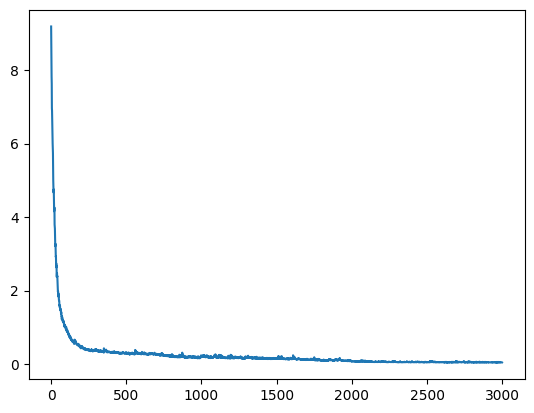

In [9]:
plt.plot(np.load(os.path.join(result_path, 'test_loss_6.npy'))[:,-1])

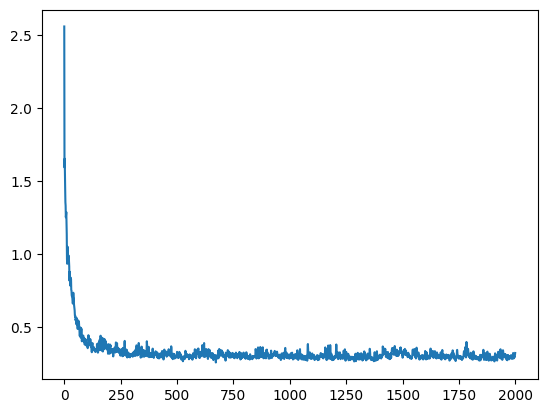

In [11]:
plt.plot(np.load(os.path.join(result_path, 'test_loss_2_1.npy'))[:,-1])

### Save the training results

In [ ]:
with open(os.path.join(result_path, 'loss_1.npy'), 'wb') as f:
    np.save(f, Double_Well_loss_value.loss_values)
with open(os.path.join(result_path, 'test_loss_1.npy'), 'wb') as f:
    np.save(f, Double_Well_solver.test_loss_values)

### Save the trained model

In [10]:
# Double_Well_solver.Obv_encoder.save(os.path.join(model_path, 'Obv_encoder_reformulate_1.keras'))
# Double_Well_solver.Value_function_solver.save(os.path.join(model_path, 'Value_function_solver_reformulate_1.keras'))

In [10]:
non_tf_controlled_sde_sampling = Double_Well_solver.controlled_sde_sampling
Double_Well_solver.controlled_sde_sampling = tf.function(Double_Well_solver.controlled_sde_sampling)

In [11]:
# Double_Well_solver.controlled_sde_sampling = non_tf_controlled_sde_sampling 

In [12]:
path_num = 3000
sample_id = 100
init_state, obv_trajectories = test_Double_Well_sig_data[sample_id][0], test_Double_Well_obv_data[sample_id]
init_state, obv_trajectories = tf.repeat(tf.expand_dims(init_state, axis=0), path_num, axis=0), tf.repeat(tf.expand_dims(obv_trajectories, axis=0), path_num, axis=0) 
sig_data = test_Double_Well_sig_data[sample_id]

In [13]:
config = Munch(reset_configuration=None)
# with tf.device('/GPU:0'):
particle_filters = Double_Well_solver.controlled_sde_sampling(init_state, obv_trajectories, config)

2024-08-27 10:23:47.889516: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


In [14]:
vanila_model.controlled_sde_sampling = tf.function(vanila_model.controlled_sde_sampling)
config = Munch(reset_configuration=None)
# with tf.device('/GPU:0'):
vanila_particle_filters = vanila_model.controlled_sde_sampling(init_state, obv_trajectories, config)

In [15]:
sig_data = test_Double_Well_sig_data[sample_id]


In [ ]:
plt.plot(test_Double_Well_sig_data[sample_id])
plt.plot(test_Double_Well_obv_data[sample_id])

In [94]:
SDE_trajectories.shape

(1, 1001, 1)

In [11]:
SDE_trajectories = np.array([test_Double_Well_sig_data[sample_id]])
noise = tfp.distributions.Normal(loc=0.0, scale=1.0).sample(sample_shape=(SDE_trajectories.shape[0], SDE_trajectories.shape[1]-1, SDE_trajectories.shape[2]))
noise = np.load('numerical_example_noise.npy')

In [12]:
noise.shape

(1, 1000, 1)

In [128]:
np.save('numerical_example_noise.npy', noise)

In [13]:
init_state, obv_trajectories = test_Double_Well_sig_data[sample_id][0], noised_observation((SDE_trajectories, noise), obv_drift, delta_t)[0]
init_state, obv_trajectories = tf.repeat(tf.expand_dims(init_state, axis=0), path_num, axis=0), tf.repeat(tf.expand_dims(obv_trajectories, axis=0), path_num, axis=0) 

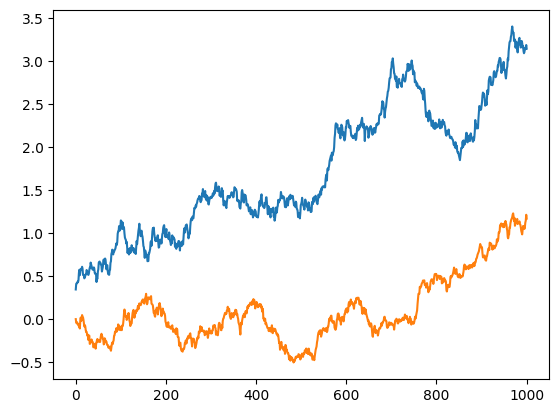

In [22]:
plt.plot(test_Double_Well_sig_data[sample_id])
plt.plot(obv_trajectories[0])

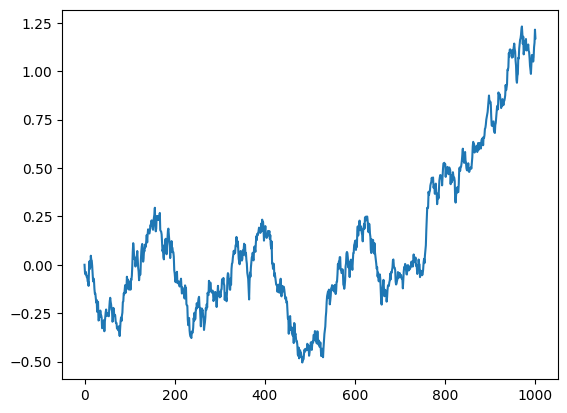

In [20]:
plt.plot(obv_trajectories[sample_id])

In [15]:
config = Munch(reset_configuration=None)
with tf.device('/GPU:0'):
    particle_filters = Double_Well_solver.controlled_sde_sampling(init_state, obv_trajectories, config)

In [22]:
tf.reshape(tf.reduce_mean(particle_filters[0], axis=0), -1)

<tf.Tensor: shape=(1001,), dtype=float32, numpy=
array([0.34505275, 0.34595966, 0.3478928 , ..., 1.8537415 , 1.8538413 ,
       1.85408   ], dtype=float32)>

In [16]:
def draw_picture(x, mean_y, bottom_boundary, upper_boundary, area_lable):
    # Plot the mean curve
    plt.plot(x, mean_y, label='Estimated mean', color='red', linestyle='--', linewidth=2)

    # Plot the error as dashed lines
    plt.fill_between(x, bottom_boundary, upper_boundary, color='red', alpha=0.2, label=area_lable)
    plt.plot(x, bottom_boundary, color='purple', linestyle='', linewidth=1)
    plt.plot(x, upper_boundary, color='purple', linestyle='', linewidth=1)

    # Add labels and legend
    plt.xlabel('time')
    plt.ylabel('$y$')
    plt.title('Particle fitering generated by the controlled diffusion')
    plt.legend()

    # Show the plot
    plt.show()
    
    
def particle_filters_std(sig_data, particle_filter_samples):
    # Generate sample data
    np.random.seed(0)
    # Generate the x-axis
    x = np.linspace(0, 1, 1001)
    plt.plot(x, tf.reshape(sig_data, -1), color='black', label='Hidden signal process')
    # Calculate mean and standard deviation
    mean_y = tf.reshape(tf.reduce_mean(particle_filter_samples, axis=0), -1)
    
    std_y =  3.0 * tf.sqrt(tf.reshape(tf.reduce_mean(tf.square(particle_filter_samples - tf.reduce_mean(particle_filter_samples, axis=0)), axis=0), -1))
    area_lable = '3x Standard error'
    draw_picture(x, mean_y , mean_y - std_y, mean_y + std_y, area_lable)
    


def particle_filters_percentile(sig_data, particle_filter_samples):
    # Generate sample data
    np.random.seed(0)
    # Generate the x-axis
    x = np.linspace(0, 1, 1001)
    plt.plot(x, tf.reshape(sig_data, -1), color='black', label='Hidden signal process')
    # Calculate mean and standard deviation
    mean_y = tf.reshape(tf.reduce_mean(particle_filter_samples, axis=0), -1)
    
    # std_y =  3.0 * tf.reshape(tf.reduce_mean(tf.square(particle_filter_samples - tf.reduce_mean(particle_filter_samples, axis=0)), axis=0), -1)

    bottom_boundary = tf.reshape(tfp.stats.percentile(particle_filter_samples, q = 10.0, axis=0), -1)
    upper_boundary = tf.reshape(tfp.stats.percentile(particle_filter_samples, q = 90.0, axis=0), -1)
    area_lable = '[0.1, 0.9] confidential interval'
    draw_picture(x, mean_y, bottom_boundary, upper_boundary, area_lable)
    # draw_picture(x, mean_y, mean_y, mean_y, area_lable)
    

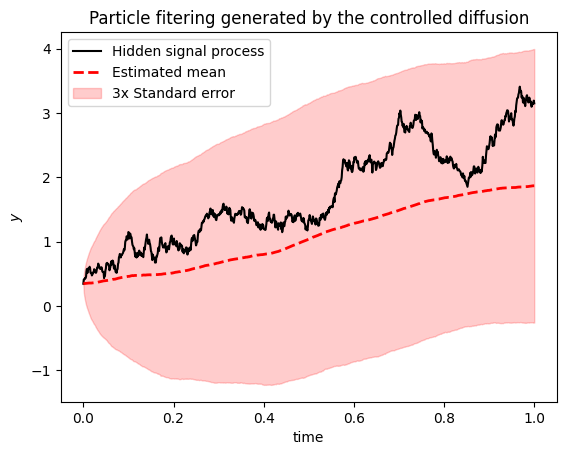

In [17]:
sig_data,  particle_filter_samples = test_Double_Well_sig_data[sample_id], particle_filters[0]
particle_filters_std(sig_data, particle_filter_samples)

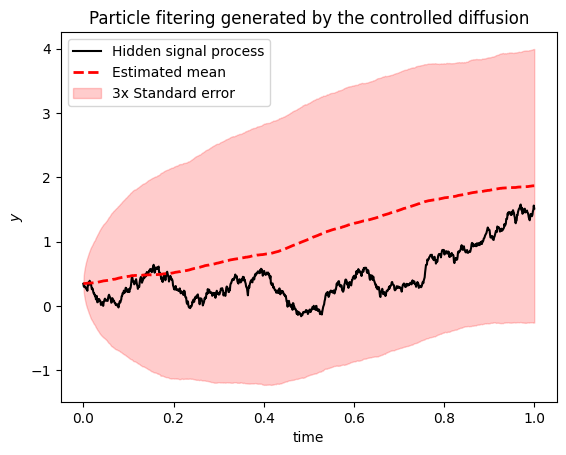

In [24]:
sig_data,  particle_filter_samples = test_Double_Well_sig_data[sample_id], particle_filters[0]
particle_filters_std(obv_trajectories[0] + init_state[0], particle_filter_samples)

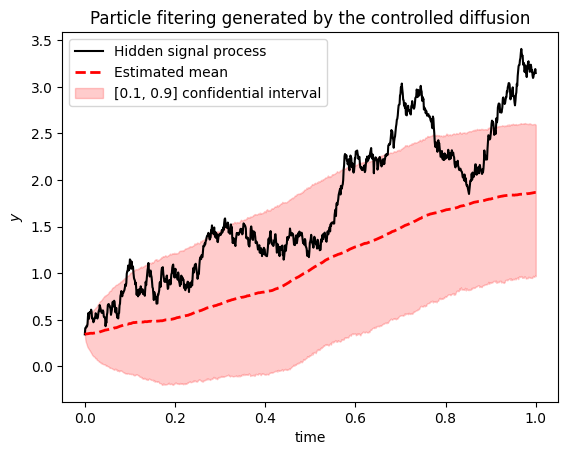

In [26]:
particle_filters_percentile(sig_data, particle_filter_samples)

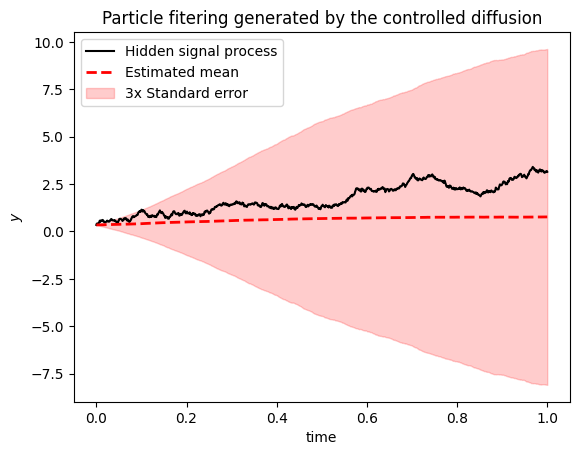

In [14]:
sig_data,  vanila_particle_filter_samples = test_Double_Well_sig_data[sample_id], vanila_particle_filters[0]
particle_filters_std(sig_data, vanila_particle_filter_samples)

In [15]:
import tensorflow_probability as tfp

bottom_boundary = tfp.stats.percentile(particle_filter_samples, q = 10.0, axis=0)
upper_boundary = tfp.stats.percentile(particle_filter_samples, q = 90.0, axis=0)

<tf.Tensor: shape=(1001, 1), dtype=float32, numpy=
array([[0.34505302],
       [0.29129055],
       [0.27252683],
       ...,
       [1.5293374 ],
       [1.5217699 ],
       [1.530482  ]], dtype=float32)>

### Contruct the Particle Filters

In [16]:
@tf.function
def path_space_RN(controlled_SDE_model, init_state, obv_trajectories, groups=1):
    batch_size, num_steps, DIM = obv_trajectories.shape
    # Prepare time steps tensor
    time_steps = tf.linspace(0.0, (num_steps - 2), num_steps - 1)
    y_hidden = controlled_SDE_model.Obv_encoder(obv_trajectories)[:, :-1, :]
    # y_hidden = self.Obv_encoder(obv_trajectories[:, 1:, :] - obv_trajectories[:, :-1, :])
    y_T = obv_trajectories[:, -1, :]
    controlled_SDE_model.controlled_sde_sampling = tf.function(controlled_SDE_model.controlled_sde_sampling)
    config = Munch(reset_configuration=None)
    particle_filter_samples_list, Gaussian_noise_list = [], []
    for i in range(groups):
        with tf.device('/GPU:0'):
            particle_filter_samples, Gaussian_noise = controlled_SDE_model.controlled_sde_sampling(init_state, obv_trajectories, config)
            particle_filter_samples_list.append(particle_filter_samples)
            Gaussian_noise_list.append(Gaussian_noise)
    particle_filter_samples, Gaussian_noise = tf.concat(particle_filter_samples_list, axis=0), tf.concat(Gaussian_noise_list, axis=0)
    init_state, obv_trajectories = tf.repeat(init_state, groups,axis=0), tf.repeat(obv_trajectories, groups, axis=0)
    # particle_filter_samples_forward = particle_filter_samples[:, 1:, :]
    y_hidden = controlled_SDE_model.Obv_encoder(obv_trajectories)[:, :-1, :]
    # y_hidden = self.Obv_encoder(obv_trajectories[:, 1:, :] - obv_trajectories[:, :-1, :])
    y_T = obv_trajectories[:, -1, :]
    batch_size *= groups
    
    
    
#     def _construct_filters(weight, filters):
#         normalized_weight = weight / tf.reduce_sum(weight, axis=0)
#         return tf.einsum('ijkl, ijk->ijl', tf.expand_dims(filters, axis=2), tf.expand_dims(normalized_weight, axis=2))
    
    def _construct_filters(weight, filters):
        normalized_weight = weight / tf.reduce_sum(weight, axis=0)
        # normalized_weight = weight / tf.reduce_mean(weight, axis=0)
        # normalized_weight = weight 
        return tf.einsum('ijlk, ij->ilk', tf.expand_dims(filters, axis=1), tf.expand_dims(normalized_weight, axis=1)), normalized_weight
    
    # def _dPX_y_dPX_normalizer(current_state, inputs):
        
    
    def _path_space_RN(current_state, inputs):
        x_t, x_t_1, t, dw, y_hidden_t, y_t = inputs
        # y_t = y_t - y_T
        t = t * controlled_SDE_model.delta_t
        sigma_T = tf.transpose(controlled_SDE_model.diffusion(x_t, t), perm=[0, 2, 1])
        sigma = controlled_SDE_model.diffusion(x_t, t)
        h = controlled_SDE_model.obv_drift(x_t)
        delta_h = controlled_SDE_model.obv_drift(x_t_1) - controlled_SDE_model.obv_drift(x_t)
        
        controlled_drift = controlled_SDE_model.controlled_drift(x_t, t, y_hidden_t, y_t - y_T)
        controlled_drift_square = tf.reduce_sum(tf.square(controlled_drift), axis=-1)
        h_square = tf.reduce_sum(tf.square(h), axis=-1)
        y_dot_delta_h = tf.einsum('ij,ij->i', y_t, delta_h)
        u_dot_dw = tf.sqrt(controlled_SDE_model.delta_t) * tf.einsum('ij, ij->i', controlled_drift, dw) 
        updated_state = current_state + 0.5 * (-1.0 * controlled_drift_square + h_square) * controlled_SDE_model.delta_t + y_dot_delta_h - u_dot_dw
        # updated_state = tf.concat([
        #     current_state[:, [0]] + 0.5 * (controlled_drift_square + h_square) * controlled_SDE_model.delta_t + y_dot_delta_h + u_dot_dw,
        #     current_state[:, [1]] + 0.5 * h_square * controlled_SDE_model.delta_t + y_dot_delta_h
        # ], axis=-1)
        return updated_state
    

    initial_accumulator = tf.zeros([batch_size], dtype=tf.float32)
    
    
    # Prepare inputs for tf.scan: (X_t, t, dw)
    trajectory_inputs = (tf.transpose(particle_filter_samples[:, :-1, :], perm=[1, 0, 2]),
                         tf.transpose(particle_filter_samples[:, 1:, :], perm=[1, 0, 2]),
                         time_steps, tf.transpose(Gaussian_noise, perm=[1, 0, 2]),
                         tf.transpose(y_hidden, perm=[1, 0, 2]),
                         tf.transpose(obv_trajectories[:, :-1, :], perm=[1, 0, 2]),)
    integral = tf.scan(_path_space_RN, trajectory_inputs, initializer=initial_accumulator)
    integral = integral[-1]

    X_T = particle_filter_samples[:, -1, :]
    y_T = obv_trajectories[:, -1, :]
    
    RN_results = tf.exp( -1.0 * (
        integral + tf.einsum('ij,ij->i', y_T, -1.0 * controlled_SDE_model.obv_drift(X_T))
    ))
    # print( RN_results.shape)
    
    return _construct_filters(RN_results, particle_filter_samples)


    

In [27]:
@tf.function
def path_space_RN(controlled_SDE_model, init_state, obv_trajectories, groups=1):
    batch_size, num_steps, DIM = obv_trajectories.shape
    # Prepare time steps tensor
    time_steps = tf.linspace(0.0, (num_steps - 2), num_steps - 1)
    y_hidden = controlled_SDE_model.Obv_encoder(obv_trajectories)[:, :-1, :]
    # y_hidden = self.Obv_encoder(obv_trajectories[:, 1:, :] - obv_trajectories[:, :-1, :])
    y_T = obv_trajectories[:, -1, :]
    controlled_SDE_model.controlled_sde_sampling = tf.function(controlled_SDE_model.controlled_sde_sampling)
    config = Munch(reset_configuration=None)
    

    
    
#     def _construct_filters(weight, filters):
#         normalized_weight = weight / tf.reduce_sum(weight, axis=0)
#         return tf.einsum('ijkl, ijk->ijl', tf.expand_dims(filters, axis=2), tf.expand_dims(normalized_weight, axis=2))
    
    def _construct_filters(weight, filters):
        normalized_weight = weight / tf.reduce_sum(weight, axis=0)
        # normalized_weight = weight / tf.reduce_mean(weight, axis=0)
        # normalized_weight = weight 
        return tf.einsum('ijlk, ij->ilk', tf.expand_dims(filters, axis=1), tf.expand_dims(normalized_weight, axis=1)), normalized_weight, filters
    
    # def _dPX_y_dPX_normalizer(current_state, inputs):
        
    
    def _path_space_RN(current_state, inputs):
        x_t, x_t_1, t, dw, y_hidden_t, y_t = inputs
        # y_t = y_t - y_T
        t = t * controlled_SDE_model.delta_t
        sigma_T = tf.transpose(controlled_SDE_model.diffusion(x_t, t), perm=[0, 2, 1])
        sigma = controlled_SDE_model.diffusion(x_t, t)
        h = controlled_SDE_model.obv_drift(x_t)
        delta_h = controlled_SDE_model.obv_drift(x_t_1) - controlled_SDE_model.obv_drift(x_t)
        
        controlled_drift = controlled_SDE_model.controlled_drift(x_t, t, y_hidden_t, y_t - y_T)
        controlled_drift_square = tf.reduce_sum(tf.square(controlled_drift), axis=-1)
        h_square = tf.reduce_sum(tf.square(h), axis=-1)
        y_dot_delta_h = tf.einsum('ij,ij->i', y_t, delta_h)
        u_dot_dw = tf.sqrt(controlled_SDE_model.delta_t) * tf.einsum('ij, ij->i', controlled_drift, dw) 
        updated_state = current_state + 0.5 * ( controlled_drift_square + h_square) * controlled_SDE_model.delta_t + y_dot_delta_h + u_dot_dw
        # updated_state = tf.concat([
        #     current_state[:, [0]] + 0.5 * (controlled_drift_square + h_square) * controlled_SDE_model.delta_t + y_dot_delta_h + u_dot_dw,
        #     current_state[:, [1]] + 0.5 * h_square * controlled_SDE_model.delta_t + y_dot_delta_h
        # ], axis=-1)
        return updated_state
    
    RN_results_list, particle_filter_samples_list = [], []
    
    for i in range(groups):
        with tf.device('/GPU:0'):
            particle_filter_samples, Gaussian_noise = controlled_SDE_model.controlled_sde_sampling(init_state, obv_trajectories, config)
    
        initial_accumulator = tf.zeros([batch_size], dtype=tf.float32)
    
    
        # Prepare inputs for tf.scan: (X_t, t, dw)
        trajectory_inputs = (tf.transpose(particle_filter_samples[:, :-1, :], perm=[1, 0, 2]),
                             tf.transpose(particle_filter_samples[:, 1:, :], perm=[1, 0, 2]),
                             time_steps, tf.transpose(Gaussian_noise, perm=[1, 0, 2]),
                             tf.transpose(y_hidden, perm=[1, 0, 2]),
                             tf.transpose(obv_trajectories[:, :-1, :], perm=[1, 0, 2]),)
        integral = tf.scan(_path_space_RN, trajectory_inputs, initializer=initial_accumulator)
        integral = integral[-1]

        X_T = particle_filter_samples[:, -1, :]
        y_T = obv_trajectories[:, -1, :]

        RN_results_list.append(tf.exp( -1.0 * (
            integral + tf.einsum('ij,ij->i', y_T, -1.0 * controlled_SDE_model.obv_drift(X_T))
        )))
        particle_filter_samples_list.append(particle_filter_samples)
    # print( RN_results.shape)
    RN_results, particle_filter_samples = tf.concat(RN_results_list, axis=0), tf.concat(particle_filter_samples_list, axis=0)
    return _construct_filters(RN_results, particle_filter_samples)


    

### Fitering evaluation

In [28]:
def particle_filters_pred(sig_data, particle_filter_samples):
    # Generate sample data
    np.random.seed(0)
    # Generate the x-axis
    x = np.linspace(0, 1, 1001)
    plt.plot(x, tf.reshape(sig_data, -1), color='black', label='Hidden signal process')
    # Calculate mean and standard deviation
    mean_y = tf.reshape(tf.reduce_sum(particle_filter_samples, axis=0), -1)
    
#     std_y =  3.0 * tf.sqrt(tf.reshape(tf.reduce_mean(tf.square(particle_filter_samples - tf.reduce_mean(particle_filter_samples, axis=0)), axis=0), -1))
#     area_lable = '3x Standard error'
    # draw_picture(x, mean_y , mean_y - std_y, mean_y + std_y, area_lable)
    
    # Plot the mean curve
    plt.plot(x, mean_y, label='Estimated mean', color='red', linestyle='--', linewidth=2)

    # Plot the error as dashed lines
    # plt.fill_between(x, bottom_boundary, upper_boundary, color='red', alpha=0.2, label=area_lable)
    # plt.plot(x, bottom_boundary, color='purple', linestyle='', linewidth=1)
    # plt.plot(x, upper_boundary, color='purple', linestyle='', linewidth=1)

    # Add labels and legend
    plt.xlabel('time')
    plt.ylabel('$y$')
    plt.title('Particle fitering generated by the controlled diffusion')
    plt.legend()

    # Show the plot
    plt.show()
    

In [29]:
path_num =1000
groups = 1
sample_id = 100
init_state, obv_trajectories = test_Double_Well_sig_data[sample_id][0], test_Double_Well_obv_data[sample_id]
init_state, obv_trajectories = tf.repeat(tf.expand_dims(init_state, axis=0), path_num, axis=0), tf.repeat(tf.expand_dims(obv_trajectories, axis=0), path_num, axis=0) 

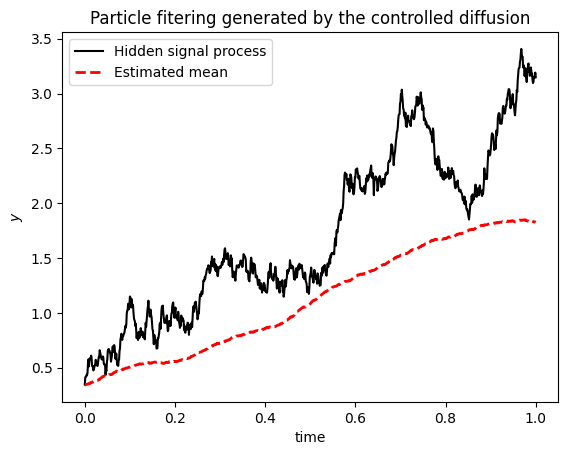

In [30]:
vanila_particle_filter_samples, vanila_weights, vanila_filters = path_space_RN(vanila_model, init_state, obv_trajectories, groups=groups)
particle_filters_pred(sig_data, vanila_particle_filter_samples)
# particle_filters_std(sig_data, vanila_particle_filter_samples)
# particle_filters_percentile(sig_data, weight_particle_filter_samples)

In [31]:
vanila_filters.shape

TensorShape([5000, 1001, 1])

In [33]:
np.mean(vanila_weights[vanila_filters[:, -1, 0] < 0])

1.3760719e-05

In [34]:
np.mean(vanila_weights[vanila_filters[:, -1, 0] > 0])

0.0002794373

In [47]:
np.min(vanila_weights)

2.897807e-09

In [50]:
np.mean(Double_Well_solver_weights[Double_Well_solver_filters[:, -1, 0] > 0])

0.00020178391

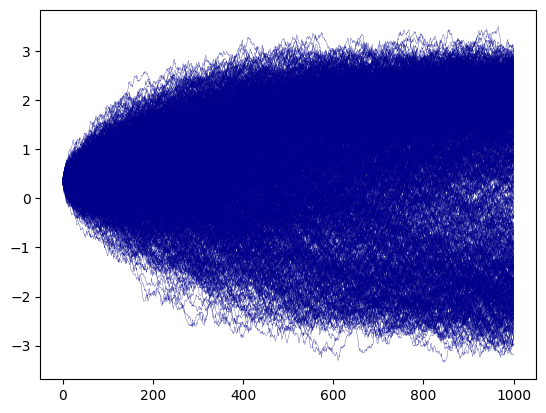

In [27]:
for trajectory in vanila_filters[:1000]:
    plt.plot(trajectory, color='darkblue', linewidth=0.2)

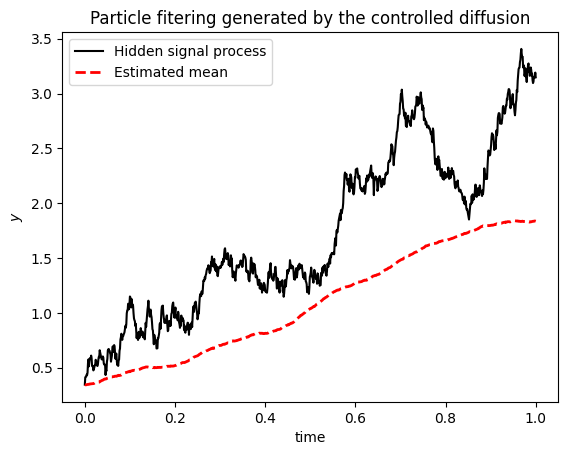

In [31]:
NN_particle_filter_samples, Double_Well_solver_weights, Double_Well_solver_filters = path_space_RN(Double_Well_solver, init_state, obv_trajectories, groups=groups)
particle_filters_pred(sig_data, NN_particle_filter_samples)
# particle_filters_std(sig_data, weight_particle_filter_samples)

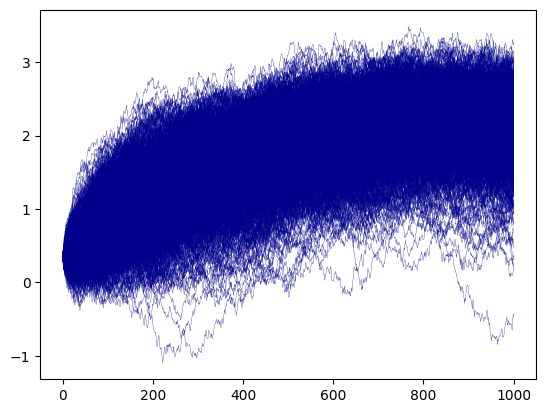

In [34]:
for trajectory in Double_Well_solver_filters[:1000]:
    plt.plot(trajectory, color='darkblue', linewidth=0.2)

In [32]:
1.0 / (path_num * groups * tf.reduce_sum(tf.square(vanila_weights)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.42897096>

In [33]:
1.0 / (path_num * groups * tf.reduce_sum(tf.square(Double_Well_solver_weights)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.98491675>

In [86]:
np.max(Double_Well_solver_weights)

0.081616715

In [87]:
np.max(vanila_weights)

0.052171584

In [85]:
tf.reduce_sum(tf.square(vanila_weights))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00076981453>

In [37]:
vanila_weights

<tf.Tensor: shape=(3000,), dtype=float32, numpy=
array([1.94353197e-04, 4.02611186e-04, 8.84403732e-07, ...,
       1.10127854e-04, 4.98281443e-04, 1.35884038e-04], dtype=float32)>

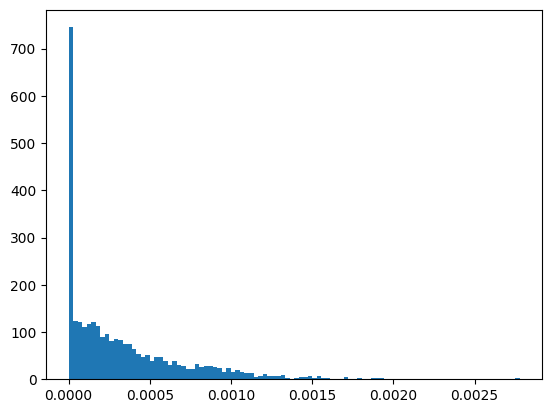

In [76]:
a = plt.hist(vanila_weights, 100)

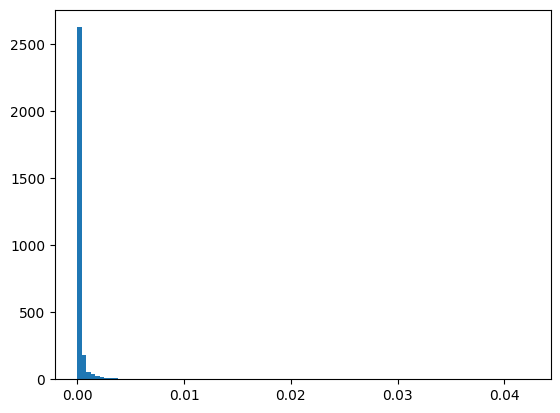

In [77]:
b = plt.hist(Double_Well_solver_weights, 100)

In [ ]:
# non_tf_controlled_sde_sampling = Double_Well_solver.controlled_sde_sampling


In [23]:
tf.Variable(np.random.normal(size=(10, 15, 3)))

<tf.Variable 'Variable:0' shape=(10, 15, 3) dtype=float64, numpy=
array([[[ 2.2408932 ,  1.86755799, -0.97727788],
        [ 0.95008842, -0.15135721, -0.10321885],
        [ 0.4105985 ,  0.14404357,  1.45427351],
        [ 0.76103773,  0.12167502,  0.44386323],
        [ 0.33367433,  1.49407907, -0.20515826],
        [ 0.3130677 , -0.85409574, -2.55298982],
        [ 0.6536186 ,  0.8644362 , -0.74216502],
        [ 2.26975462, -1.45436567,  0.04575852],
        [-0.18718385,  1.53277921,  1.46935877],
        [ 0.15494743,  0.37816252, -0.88778575],
        [-1.98079647, -0.34791215,  0.15634897],
        [ 1.23029068,  1.20237985, -0.38732682],
        [-0.30230275, -1.04855297, -1.42001794],
        [-1.70627019,  1.9507754 , -0.50965218],
        [-0.4380743 , -1.25279536,  0.77749036]],

       [[-1.61389785, -0.21274028, -0.89546656],
        [ 0.3869025 , -0.51080514, -1.18063218],
        [-0.02818223,  0.42833187,  0.06651722],
        [ 0.3024719 , -0.63432209, -0.36274117],
 

In [25]:
tf.Variable(np.random.normal(size=(10, 15)))

<tf.Variable 'Variable:0' shape=(10, 15) dtype=float64, numpy=
array([[ 2.38103148e-01, -1.40596292e+00, -5.90057646e-01,
        -1.10489405e-01, -1.66069981e+00,  1.15147873e-01,
        -3.79147563e-01, -1.74235620e+00, -1.30324275e+00,
         6.05120084e-01,  8.95555986e-01, -1.31908640e-01,
         4.04761812e-01,  2.23843563e-01,  3.29622982e-01],
       [ 1.28598401e+00, -1.50699840e+00,  6.76460732e-01,
        -3.82008956e-01, -2.24258934e-01, -3.02249730e-01,
        -3.75147117e-01, -1.22619619e+00,  1.83339199e-01,
         1.67094303e+00, -5.61330204e-02, -1.38504274e-03,
        -6.87299037e-01, -1.17474546e-01,  4.66166426e-01],
       [-3.70242441e-01, -4.53804041e-01,  4.03264540e-01,
        -9.18004770e-01,  2.52496627e-01,  8.20321797e-01,
         1.35994854e+00, -9.03820073e-02,  1.36759724e+00,
         1.03440989e+00, -9.96212640e-01, -1.21793851e+00,
        -3.04963638e-01,  1.02893549e+00, -7.22870076e-02],
       [-6.00657558e-01,  1.55224318e+00,  2.8690

In [21]:
weight = tf.Variable(np.random.normal(size=(10, 15)))
filters = tf.Variable(np.random.normal(size=(10, 15, 3)))

In [24]:
normalized_weight = weight / tf.reduce_sum(weight, axis=0)
tf.einsum('ijkl, ijk->ijl', tf.expand_dims(filters, axis=2), tf.expand_dims(normalized_weight, axis=2))

<tf.Tensor: shape=(10, 15, 3), dtype=float64, numpy=
array([[[-3.94612497e-02,  9.90754023e-01, -4.30660385e-01],
        [-4.39363161e+00, -5.23407493e-01, -3.52727884e+00],
        [-9.36100402e-01,  8.97294591e-01,  9.53409922e-01],
        [-6.35677533e-01, -7.23100834e-01,  2.80151672e+00],
        [ 2.41023704e+00,  2.22261029e-01, -3.11093886e+00],
        [ 1.68297870e-01, -1.99362262e-01, -3.07902754e-01],
        [ 3.30782655e-01,  8.82462034e-02,  2.56394350e-01],
        [-9.14763957e-03, -2.45914577e-02,  1.86847530e-02],
        [-7.05769214e-02,  4.65121350e-02, -5.48248229e-02],
        [-4.15469260e-02, -2.74468585e-02,  1.05315867e-03],
        [-1.43449182e-02, -5.57172402e-02, -2.60813902e-02],
        [-4.75355976e+00,  1.33672342e+00, -3.42514438e+00],
        [ 9.84995959e-01, -4.65258669e-02,  6.59613865e-01],
        [ 1.94610569e-01, -1.63059779e-01,  3.36814193e-02],
        [-1.51714817e-02, -4.51131308e-01,  2.02095538e-01]],

       [[-1.87635220e-02,  8.4

In [37]:
tf.expand_dims(normalized_weight, axis=2)

<tf.Tensor: shape=(10, 15, 1), dtype=float64, numpy=
array([[[ 4.86816949e-01],
        [ 5.05631845e-02],
        [ 2.57061841e-01],
        [ 1.90817881e-01],
        [-1.57872584e+02],
        [-1.23679601e-02],
        [ 4.00361858e-01],
        [ 2.24051354e-01],
        [-8.12095824e-02],
        [-2.25807550e-01],
        [-1.00598570e-02],
        [-3.58557814e-01],
        [ 5.05150483e-01],
        [ 1.10312648e-01],
        [ 6.51567240e-03]],

       [[ 5.30846686e-01],
        [ 7.28844015e-01],
        [-1.56168990e-01],
        [ 6.07571552e-03],
        [-2.05090666e+02],
        [-5.99488978e-02],
        [ 9.32703753e-02],
        [ 8.89312346e-01],
        [ 1.79074320e-02],
        [ 9.91613597e-02],
        [ 6.67229866e-01],
        [ 3.34333607e-02],
        [-6.82151279e-01],
        [-5.65466450e-01],
        [ 2.06807283e-01]],

       [[-3.85019713e-01],
        [-1.62296283e+00],
        [ 4.64578120e-02],
        [ 1.50545392e-01],
        [ 9.43052091e+01]